In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

from sqlalchemy import create_engine
from sqlalchemy import text

from wordcloud import WordCloud

In [2]:
mpl.rcParams["xtick.labelsize"] = 20
mpl.rcParams["ytick.labelsize"] = 20
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["axes.titlesize"] = 30
mpl.rcParams["mathtext.fontset"] = "cm"
#mpl.rcParams["font.serif"] = True

In [3]:
engine = create_engine("sqlite:///../data/news.db")

In [4]:
conn = engine.connect()

---

# Exploratory data analysis

We can check how many articles there are for each publication.

Most articles are from Reuters.

In [5]:
query = "SELECT publication, COUNT(*) AS num FROM articles GROUP BY publication ORDER BY num DESC"

results = conn.execute(text(query))

df_pub = pd.DataFrame(results.fetchall(), columns = results.keys())

In [6]:
df_pub.publication = df_pub.publication.where(~(df_pub.publication == ""), "Unknown")

<BarContainer object of 27 artists>

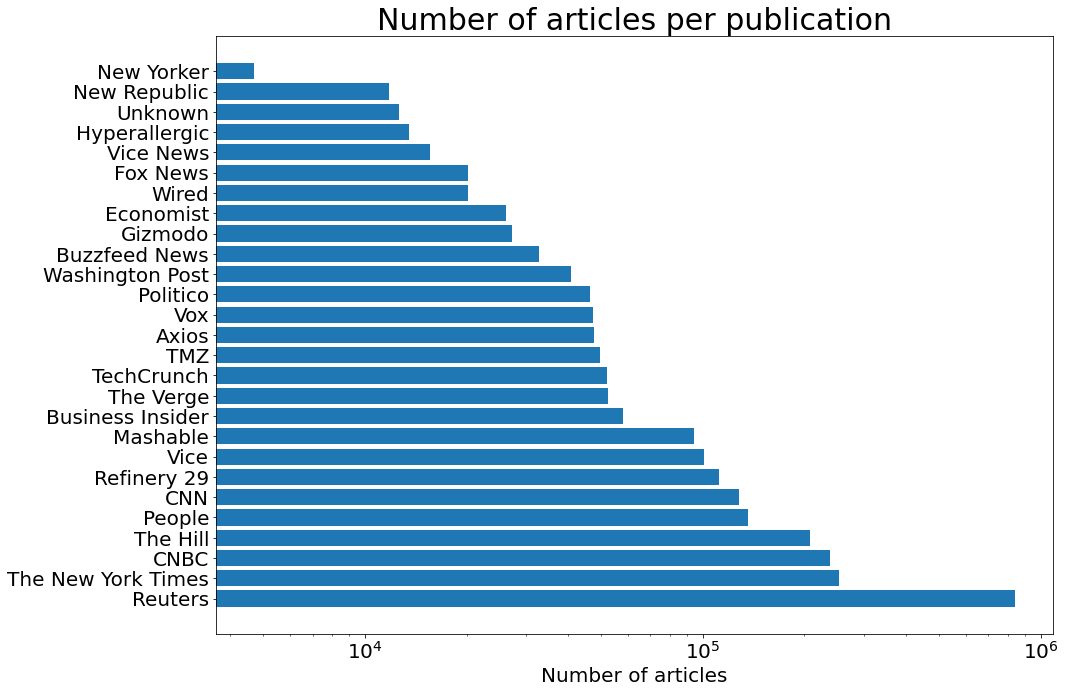

In [7]:
fig, ax = plt.subplots(figsize=(15,11))

ax.set_title("Number of articles per publication")
ax.set_xlabel("Number of articles")

ax.barh(df_pub.publication, width=df_pub.num, log=True)

---

We can check how many articles there are for each section.

There are over 900k unsorted. The majority are in the sections we would expect, e.g., world news, politics, etc.

Importantly we see that there are 2 politics sections that appear with different casing "politics" and "Politics".

In [8]:
query = "SELECT section, COUNT(*) AS num FROM articles GROUP BY section ORDER BY num DESC"

results = conn.execute(text(query))

df_sec = pd.DataFrame(results.fetchall(), columns = results.keys())

In [9]:
df_sec.section = df_sec.section.where(~(df_sec.section == ""), "Unknown")

<BarContainer object of 20 artists>

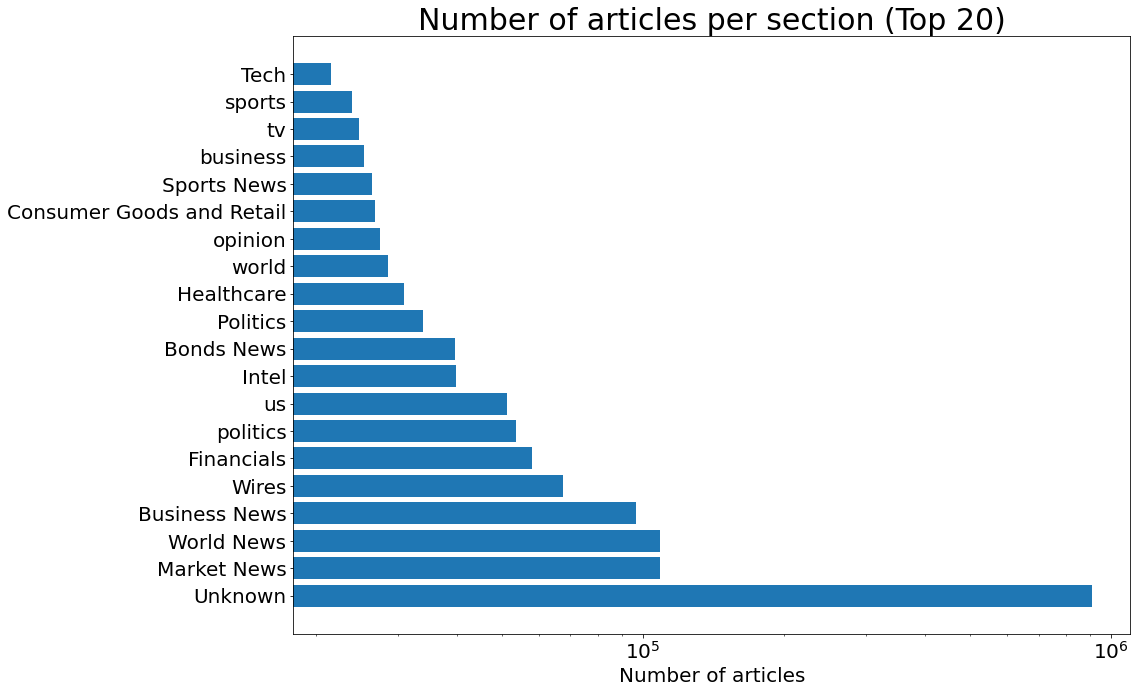

In [10]:
fig, ax = plt.subplots(figsize=(15,11))

ax.set_title("Number of articles per section (Top 20)")
ax.set_xlabel("Number of articles")

ax.barh(df_sec.section.head(20), width=df_sec.num.head(20), log=True)

---

Since we are interested in the politics articles, we can check which sections contain the string "politic", this will match "politics", "political", etc.

As we saw before, we will have to check for case-insensitive matches.

Most of them are in "politics" or "Politics" as expected but there are also smaller section for different countries as well as many other sections that seem to be connected with a specific article.

<BarContainer object of 20 artists>

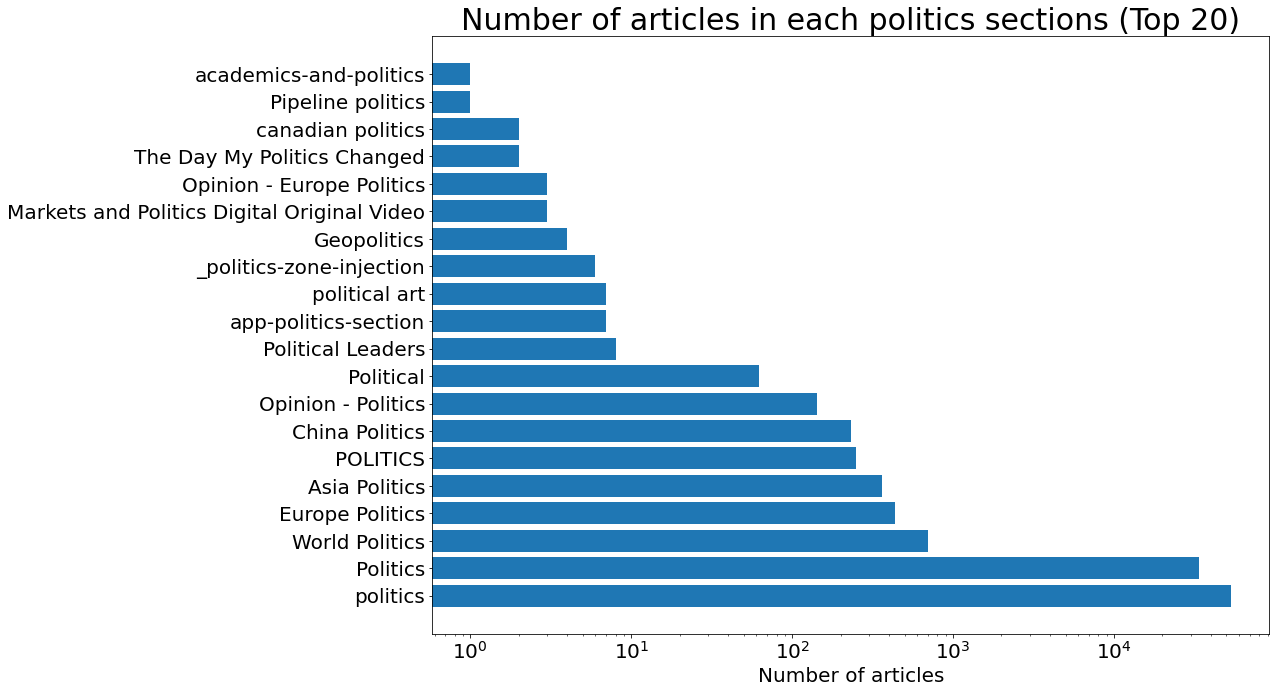

In [11]:
fig, ax = plt.subplots(figsize=(15,11))

ax.set_title("Number of articles in each politics sections (Top 20)")
ax.set_xlabel("Number of articles")

ax.barh(df_sec[df_sec.section.str.contains("politic", case=False)].head(20).section, width=df_sec[df_sec.section.str.contains("politic", case=False)].head(20).num, log=True)

---

We can check which years the articles are from.

The years range from 2016 - 2020 with the fewest articles in 2020.

In [12]:
#query = "SELECT strftime('%Y', date) AS yr, COUNT(*) AS num FROM articles GROUP BY yr"
query = "SELECT year, COUNT(*) AS num FROM articles GROUP BY year"

results = conn.execute(text(query))

df_year = pd.DataFrame(results.fetchall(), columns = results.keys())

<BarContainer object of 5 artists>

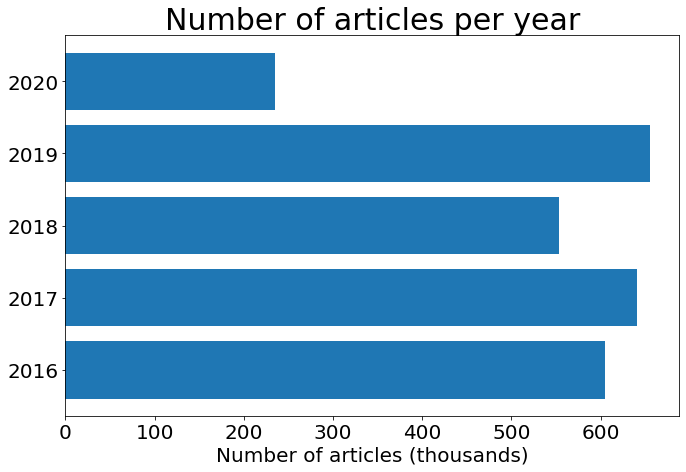

In [13]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Number of articles per year")
ax.set_xlabel("Number of articles (thousands)")

ax.barh(df_year.year, width=df_year.num/1000)

---

We can check how many articles are political articles for each year by going through the above politics sections. We can focus only on the sections with more than 10 articles.

There are only 5k politics article in 2020.

In [14]:
politics_sec = df_sec[df_sec.section.str.contains("politic", case=False)]
politics_sec.reset_index(drop=True, inplace=True)
politics_sec = politics_sec[politics_sec["num"] > 10]

In [15]:
df_politics_year = None

query = "SELECT year, COUNT(*) AS num FROM articles WHERE section = :sec GROUP BY year"

for s in politics_sec.section:
    results = conn.execute(text(query), {"sec": s})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_politics_year = pd.concat([df_politics_year, temp_df])

df_politics_year = df_politics_year.groupby("year").sum()

<BarContainer object of 5 artists>

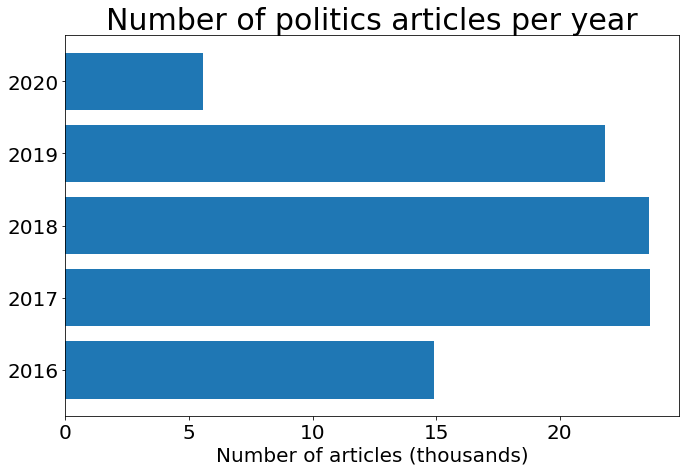

In [16]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Number of politics articles per year")
ax.set_xlabel("Number of articles (thousands)")

ax.barh(df_politics_year.index, width=df_politics_year.num/1000)

---

# 2016

Let's explore all the politics articles from 2016

In [17]:
df_politics_2016 = None

query = "SELECT * FROM articles WHERE year = 2016 AND section = :sec"

for s in politics_sec.section:
    results = conn.execute(text(query), {"sec": s})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_politics_2016 = pd.concat([df_politics_2016, temp_df])
#conn.close()

In [18]:
df_politics_2016

id                 date  year month day             author  \
0       28115  2016-02-02 18:05:00  2016     2   2       Osman Faruqi   
1       51350  2016-12-27 15:03:00  2016    12  27     Tshepo Mokoena   
2       56242  2016-12-13 16:00:00  2016    12  13    Matthew Goodwin   
3       58574  2016-12-23 15:20:00  2016    12  23     Jessi Phillips   
4       99446  2016-12-12 21:45:00  2016    12  12      Harry Cheadle   
...       ...                  ...   ...   ...  ..                ...   
4768  1624288           2016-10-20  2016    10  20                      
4769  1624295           2016-05-20  2016     5  20                      
4770  1624447           2016-10-15  2016    10  15      Steve Holland   
4771  1624867           2016-11-15  2016    11  15         Bill Trott   
4772  1625000           2016-03-10  2016     3  10  Patricia Zengerle   

                                                  title  \
0     Australian Politics Has a Sexual Harassment Pr...   
1                   Why Authoritarianism Refuses to Die   
2           Populists May Seize Even More Power in 2017   
3     How to Run for Office with No Money and Little...   
4     America Is Not Prepared for President @RealDon...   
...                                                 ...   
4768  Voters illegally removed from Ohio rolls may c...   
4769  NRA, the top U.S. gun lobby group, endorses Tr...   
4770  How Trump rallies the faithful: Belittle Clint...   
4771  Bannon role in Trump administration sets off c...   
4772  Senate banking panel approves Szubin for key s...   

                                                article  \
0     This article originally appeared on VICE Austr...   
1      There's a fascist in every one of us. Yeah, y...   
2     This post originally appeared on VICE UK. For ...   
3     Matt Hummel wasn't a complete political novice...   
4     Most mornings these days, I wake up, check the...   
...                                                 ...   
4768  (Reuters) - A federal judge in Ohio laid out a...   
4769  WASHINGTON (Reuters) - The National Rifle Asso...   
4770  CHARLOTTE, N.C. (Reuters) - Republican preside...   
4771  WASHINGTON (Reuters) - White supremacists and ...   
4772  WASHINGTON (Reuters) - The Senate Banking Comm...   

                                                    url   section publication  
0     https://www.vice.com/en_us/article/nn9yxz/all-...  politics        Vice  
1     https://www.vice.com/en_us/article/ypve8y/what...  politics        Vice  
2     https://www.vice.com/en_us/article/pgpmdk/popu...  politics        Vice  
3     https://www.vice.com/en_us/article/4xw8mj/how-...  politics        Vice  
4     https://www.vice.com/en_us/article/78be99/amer...  politics        Vice  
...                                                 ...       ...         ...  
4768  http://www.reuters.com/article/us-election-ohi...  Politics     Reuters  
4769  http://www.reuters.com/article/us-usa-election...  Politics     Reuters  
4770  http://www.reuters.com/article/us-usa-election...  Politics     Reuters  
4771  http://www.reuters.com/article/us-usa-trump-ba...  Politics     Reuters  
4772  http://www.reuters.com/article/us-usa-treasury...  Politics     Reuters  

[14906 rows x 11 columns]

---

 Most of them are from CNN

<BarContainer object of 6 artists>

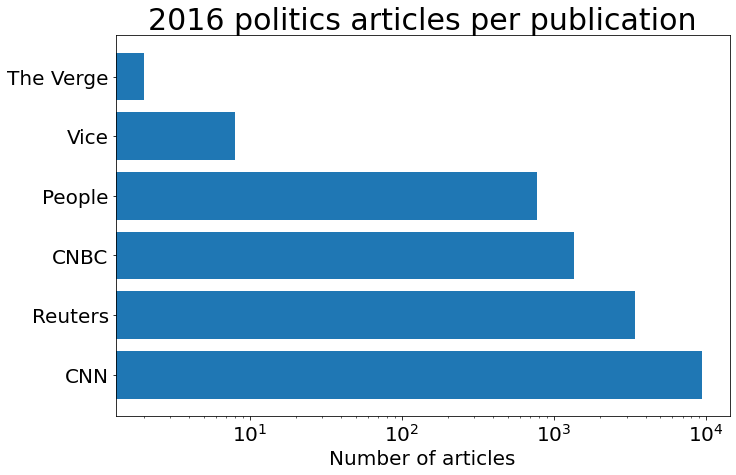

In [19]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2016 politics articles per publication")
ax.set_xlabel("Number of articles")

ax.barh(df_politics_2016.groupby("publication").count().sort_values(by="id", ascending=False).index, width=df_politics_2016.groupby("publication").count().sort_values(by="id", ascending=False)["id"], log=True)

---

## Preprocessing

There are a few articles that are empty or only contain a blank space and will need to be dropped.

In [20]:
(df_politics_2016.article == "").value_counts()

False    14899
True         7
Name: article, dtype: int64

In [21]:
articles_to_drop = df_politics_2016[df_politics_2016.article == ""]
articles_to_drop

id                 date  year month day author  \
3638   853707  2016-04-17 00:00:00  2016     4  17          
3742   854456  2016-04-21 00:00:00  2016     4  21          
3872   855363  2016-04-27 00:00:00  2016     4  27          
4060   856497  2016-05-05 00:00:00  2016     5   5          
4343   858315  2016-05-18 00:00:00  2016     5  18          
5373   864487  2016-07-03 00:00:00  2016     7   3          
10032  891040  2016-12-13 00:00:00  2016    12  13          

                            title article  \
3638                        Error           
3742                        Error           
3872                        Error           
4060                        Error           
4343                        Error           
5373                        Error           
10032  All the President’s tweets           

                                                     url   section publication  
3638   https://www.cnn.com/2016/04/17/politics/hillar...  politics         CNN  
3742   https://www.cnn.com/2016/04/21/politics/f22-ra...  politics         CNN  
3872   https://www.cnn.com/2016/04/27/politics/obama-...  politics         CNN  
4060   https://www.cnn.com/2016/05/05/politics/donald...  politics         CNN  
4343   https://www.cnn.com/2016/05/18/politics/ed-ren...  politics         CNN  
5373   https://www.cnn.com/2016/07/03/politics/failed...  politics         CNN  
10032  https://www.cnn.com/2016/12/13/politics/donald...  politics         CNN

In [22]:
df_politics_2016.drop(articles_to_drop.index, inplace=True)
df_politics_2016.reset_index(drop=True, inplace=True)
(df_politics_2016.article == "").value_counts()

False    14894
Name: article, dtype: int64

In [23]:
(df_politics_2016.article == " ").value_counts()

False    14818
True        76
Name: article, dtype: int64

In [24]:
articles_to_drop = df_politics_2016[df_politics_2016.article == " "]
articles_to_drop.head()

id                 date  year month day author  \
861   835366  2016-01-07 00:00:00  2016     1   7          
1198  837515  2016-01-19 00:00:00  2016     1  19          
1234  837741  2016-01-20 00:00:00  2016     1  20          
1254  837836  2016-01-20 00:00:00  2016     1  20          
1288  837995  2016-01-21 00:00:00  2016     1  21          

                                                  title article  \
861       Full results: CNN/ORC poll on guns in America           
1198  CNN/WMUR poll full results: New Hampshire Demo...           
1234   New Hampshire CNN/WMUR poll results: Republicans           
1254  CNN/WMUR poll full results: General election m...           
1288                    Iowa CNN/ORC poll: Full results           

                                                    url   section publication  
861   https://www.cnn.com/2016/01/07/politics/obama-...  politics         CNN  
1198  https://www.cnn.com/2016/01/19/politics/new-ha...  politics         CNN  
1234  https://www.cnn.com/2016/01/20/politics/new-ha...  politics         CNN  
1254  https://www.cnn.com/2016/01/20/politics/new-ha...  politics         CNN  
1288  https://www.cnn.com/2016/01/21/politics/iowa-p...  politics         CNN

In [25]:
df_politics_2016.drop(articles_to_drop.index, inplace=True)
df_politics_2016.reset_index(drop=True, inplace=True)
(df_politics_2016.article == " ").value_counts()

False    14818
Name: article, dtype: int64

---

Most articles are about the same length but there are a few extremely long ones and extremely short.

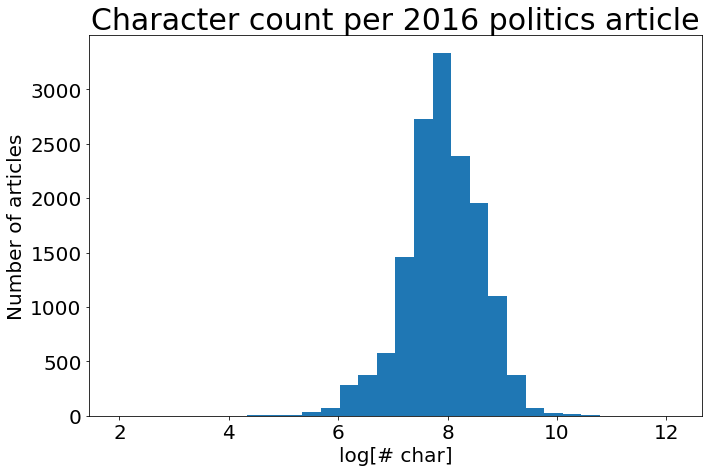

In [26]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2016 politics article")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

ax.hist(np.log(df_politics_2016.article.str.len()), bins=30);

In [27]:
article_lengths = df_politics_2016.article.str.len().sort_values()
article_lengths

1724          7
2789          7
7586         11
8083         17
5833         19
          ...  
14045     67268
4087      71018
1687     107383
2792     124836
3524     188526
Name: article, Length: 14818, dtype: int64

---

The long ones seem to correspond to debate transcripts.

In [28]:
df_politics_2016.iloc[article_lengths.index[-5:]]

id                 date  year month day author  \
14045  1418207           2016-11-28  2016    11  28          
4087    857099  2016-05-10 00:00:00  2016     5  10          
1687    840694  2016-02-03 00:00:00  2016     2   3          
2792    847839  2016-03-10 00:00:00  2016     3  10          
3524    853237  2016-04-14 00:00:00  2016     4  14          

                                                   title  \
14045  The 141 Stances Donald Trump Took During His W...   
4087   Transcript: Jon Stewart finally weighs in on 2...   
1687             Democratic town hall: Transcript, video   
2792   Transcript of Republican debate in Miami, full...   
3524   Full transcript: CNN Democratic debate in New ...   

                                                 article  \
14045  President-Elect Donald Trump took 141 distinct...   
4087   The Axe Files, featuring David Axelrod, is a p...   
1687   Transcript of the CNN Democratic Town Hall in ...   
2792    (CNN)TAPPER: Live from the Bank United Center...   
3524    (CNN)The full transcript from the CNN Democra...   

                                                     url   section publication  
14045  https://www.cnbc.com/2016/11/28/the-141-stance...  Politics        CNBC  
4087   https://www.cnn.com/2016/05/10/politics/jon-st...  politics         CNN  
1687   https://www.cnn.com/2016/02/03/politics/democr...  politics         CNN  
2792   https://www.cnn.com/2016/03/10/politics/republ...  politics         CNN  
3524   https://www.cnn.com/2016/04/14/politics/transc...  politics         CNN

---

The short ones seem to be corrupted.

In [29]:
df_politics_2016.iloc[article_lengths.index[:5]]

id                 date  year month day        author  \
1724  840916  2016-02-04 00:00:00  2016     2   4                 
2789  847823  2016-03-10 00:00:00  2016     3  10     Tal Kopan   
7586  878359  2016-10-05 00:00:00  2016    10   5  David Wright   
8083  881052  2016-10-19 00:00:00  2016    10  19     Tal Kopan   
5833  867541  2016-07-25 00:00:00  2016     7  25     Tal Kopan   

                                                  title              article  \
1724      CNN/WMUR New Hampshire GOP poll: Full results               (CNN)    
2789                    Republican debate: Live updates               (CNN)    
7586  Vice presidential debate: The number of times ...           (CNN)23.     
8083      Presidential debate live updates, live stream    Washington (CNN)    
5833                                   DNC live updates  Philadelphia (CNN)    

                                                    url   section publication  
1724  https://www.cnn.com/2016/02/04/politics/gop-ne...  politics         CNN  
2789  https://www.cnn.com/2016/03/10/politics/republ...  politics         CNN  
7586  https://www.cnn.com/2016/10/05/politics/elaine...  politics         CNN  
8083  https://www.cnn.com/2016/10/19/politics/debate...  politics         CNN  
5833  https://www.cnn.com/2016/07/25/politics/dnc-li...  politics         CNN

---

Based on the above distribution of article lengths, we can assume that articles with $\le e^6$ characters ($\approx 80$ words) are likely corrupted or too short and will be dropped.

In [30]:
df_politics_2016 = df_politics_2016[df_politics_2016.article.str.len() > int(np.exp(6))]
df_politics_2016.reset_index(drop=True, inplace=True)

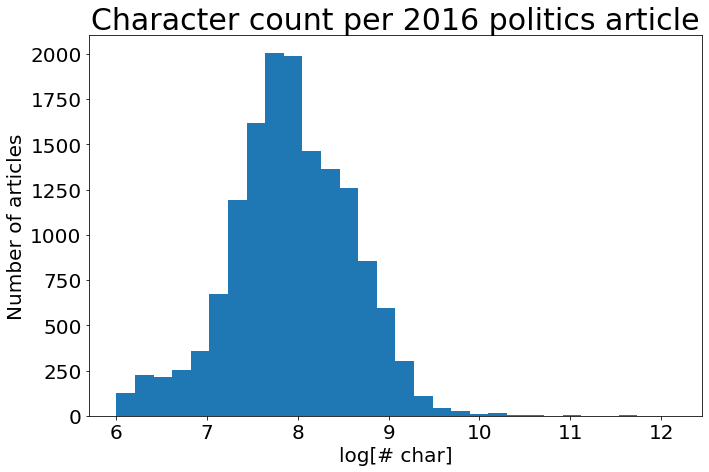

In [31]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2016 politics article")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

plt.hist(np.log(df_politics_2016.article.str.len()), bins=30);

---

The final number of articles is 14705

In [32]:
len(df_politics_2016)

14705

---

Finally, it's important that all the words are lowercase so they can be matched to stop words and with each other.

In [33]:
df_politics_2016.article = df_politics_2016.article.str.lower()
df_politics_2016.head()

/tmp/ipykernel_707/2511584571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_politics_2016.article = df_politics_2016.article.str.lower()


id                 date  year month day           author  \
0  28115  2016-02-02 18:05:00  2016     2   2     Osman Faruqi   
1  51350  2016-12-27 15:03:00  2016    12  27   Tshepo Mokoena   
2  56242  2016-12-13 16:00:00  2016    12  13  Matthew Goodwin   
3  58574  2016-12-23 15:20:00  2016    12  23   Jessi Phillips   
4  99446  2016-12-12 21:45:00  2016    12  12    Harry Cheadle   

                                               title  \
0  Australian Politics Has a Sexual Harassment Pr...   
1                Why Authoritarianism Refuses to Die   
2        Populists May Seize Even More Power in 2017   
3  How to Run for Office with No Money and Little...   
4  America Is Not Prepared for President @RealDon...   

                                             article  \
0  this article originally appeared on vice austr...   
1   there's a fascist in every one of us. yeah, y...   
2  this post originally appeared on vice uk. for ...   
3  matt hummel wasn't a complete political novice...   
4  most mornings these days, i wake up, check the...   

                                                 url   section publication  
0  https://www.vice.com/en_us/article/nn9yxz/all-...  politics        Vice  
1  https://www.vice.com/en_us/article/ypve8y/what...  politics        Vice  
2  https://www.vice.com/en_us/article/pgpmdk/popu...  politics        Vice  
3  https://www.vice.com/en_us/article/4xw8mj/how-...  politics        Vice  
4  https://www.vice.com/en_us/article/78be99/amer...  politics        Vice

---

In [34]:
#import nltk
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
#from sklearn.decomposition import TruncatedSVD

In [35]:
def display_topics(model, features, no_top_words=10):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]
        print("\n Topic %02d" % topic)
        for i in range(no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], word_vector[largest[i]]*100.0/total))

In [36]:
#stopwords = nltk.corpus.stopwords.words("english")

In [37]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "NER"])

 We will use spaCy to tokenize the articles, remove stopwords, numbers, punctuations, spaces, and perform lemmatization.

In [149]:
def spacy_tokenizer(doc):
    return [word.lemma_ for word in nlp(doc) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]

# Non-negative matrix factorization (NMF)

Non-negative matrix factorization (NMF) is an algorithm for approximating a matrix $V$ with a low rank matrix $WH$ so that $V \approx W H$.
Typically the quality of the approximation is measured by using the Frobenius norm as a measure of the error.
When the error is instead measured by the Kullback–Leibler divergence, NMF is identical to the probabilistic latent semantic analysis (PLSA).

NMF is commonly used in topic modeling since the non-negative entries of all matrices make it easy to interpret. Pictorially the procedure is shown below.

<center>
<figure>
<img src="nmf_decomp.png" style="width:50%">
<figcaption align = "center"> Adapted from Blueprints for Text Analytics Using Python: Machine Learning-Based Solutions for Common Real World (NLP) Applications </figcaption>
</figure>
</center>

For a given document-word matrix $V$ where the documents are the rows and the columns correspond to the frequency of words appearing in each document (e.g. measured using TF-IDF), the NMF decomposition results in the matrices $W$ and $H$. The rows of $W$ correspond to the features in each document and the columns of $H$ correspond to the words in each feature. This lends to the interpretation of each of the features as a "topic". After factorization, we can assign a topic to each document based on the largest value in each row of $W$.

In [39]:
tfidf_text_2016 = TfidfVectorizer(tokenizer=spacy_tokenizer, min_df=5, max_df=0.7)
vectors_text_2016 = tfidf_text_2016.fit_transform(df_politics_2016["article"])

In [40]:
nmf_text_model_2016 = NMF(n_components=15, random_state=43, alpha_W=0.0, alpha_H="same")
W_text_matrix_2016 = nmf_text_model_2016.fit_transform(vectors_text_2016)
H_text_matrix_2016 = nmf_text_model_2016.components_

In [108]:
df_politics_2016["topic"] = np.argmax(W_text_matrix_2016, axis=1)

/tmp/ipykernel_707/3287341193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_politics_2016["topic"] = np.argmax(W_text_matrix_2016, axis=1)


We can form a word clout of the top 200 words from each topic, based on the relative magnitudes in the rows of the $H$ matrix.

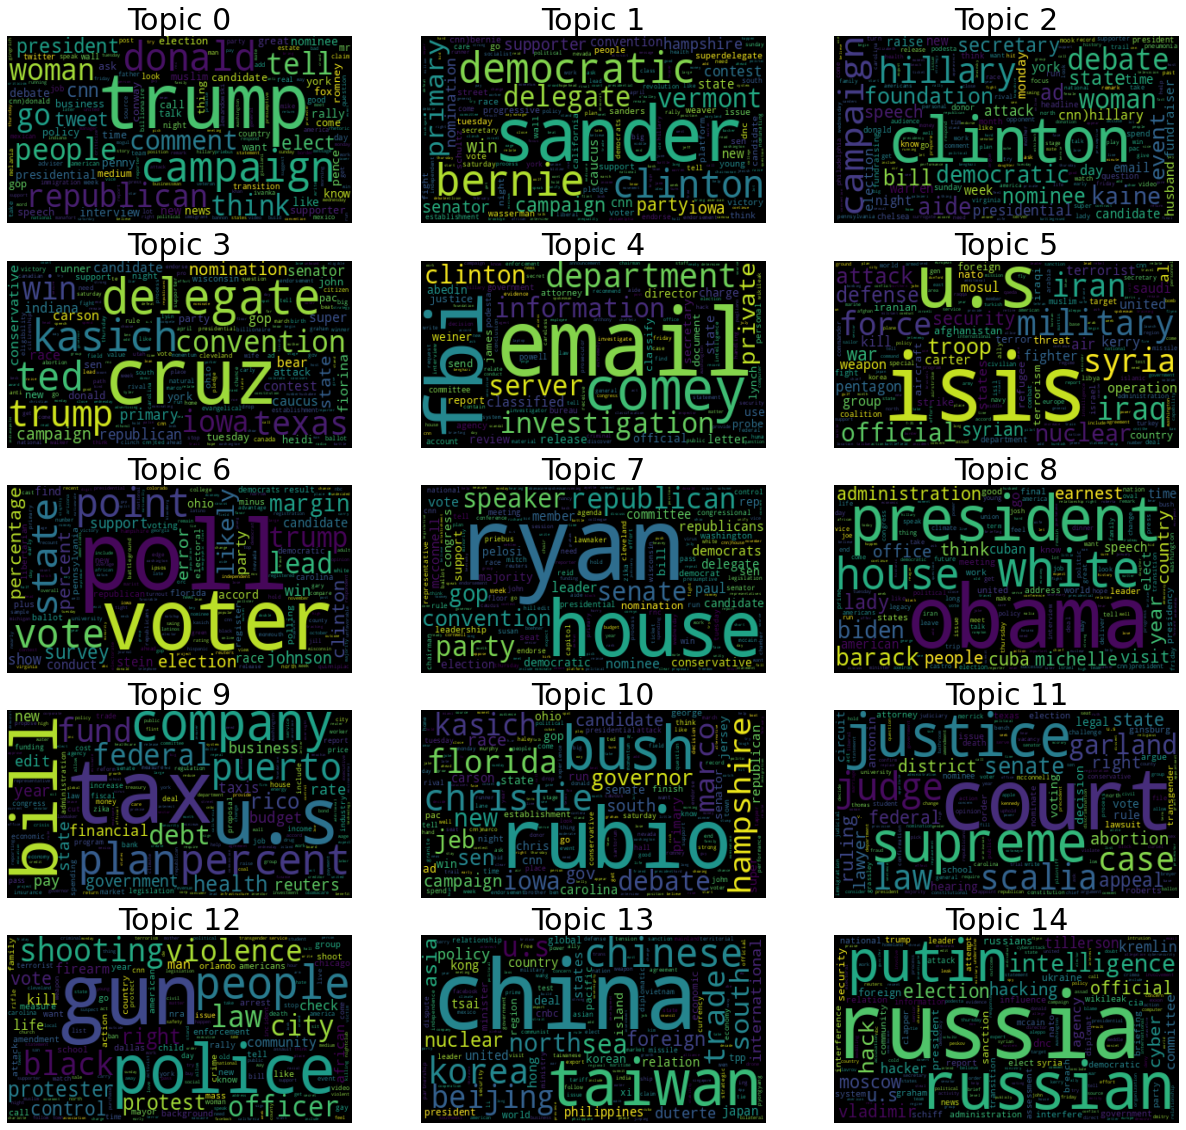

In [265]:
fig, axs = plt.subplots(5,3, figsize=(21,20))

words = tfidf_text_2016.get_feature_names_out()
for topic, weights in enumerate(H_text_matrix_2016):
        largest = weights.argsort()[::-1]
        d = {}
        for i in range(200):
            d[words[largest[i]]] = weights[largest[i]]

        wocl = WordCloud()
        wocl.generate_from_frequencies(d)
        
        axs[topic//3, topic%3].set_title("Topic %d" % topic)
        axs[topic//3, topic%3].imshow(wocl, aspect='auto', interpolation='bilinear')
        axs[topic//3, topic%3].axis("off")

In [267]:
#display_topics(nmf_text_model_2016, tfidf_text_2016.get_feature_names_out())

We can sample a few articles from each topic to figure out what topic is about

In [338]:
df_politics_2016.groupby("topic").sample(3, random_state=234)

In [339]:
#[print(df_politics_2016[df_politics_2016.topic == 7].sample(10, random_state=9151).article.iloc[i], "\n\n --- \n\n") for i in range(10)];

We can make a dictionary that maps the topic number to a few words that describe what the topic is about.

In [340]:
topic_dict_2016 = {
    0:  "trump campaign",
    1:  "sanders campaign",
    2:  "clinton campaign",
    3:  "ted cruz campaign",
    4:  "clinton emails",
    5:  "middle east",
    6:  "presidential election",
    7:  "paul ryan",
    8:  "obama",
    9:  "fiscal policy",
    10: "gop primary",
    11: "supreme court",
    12: "guns/violence",
    13: "foreign policy CN/NK",
    14: "russia hack"
}

We can look at the total number of articles for each topic.

<BarContainer object of 15 artists>

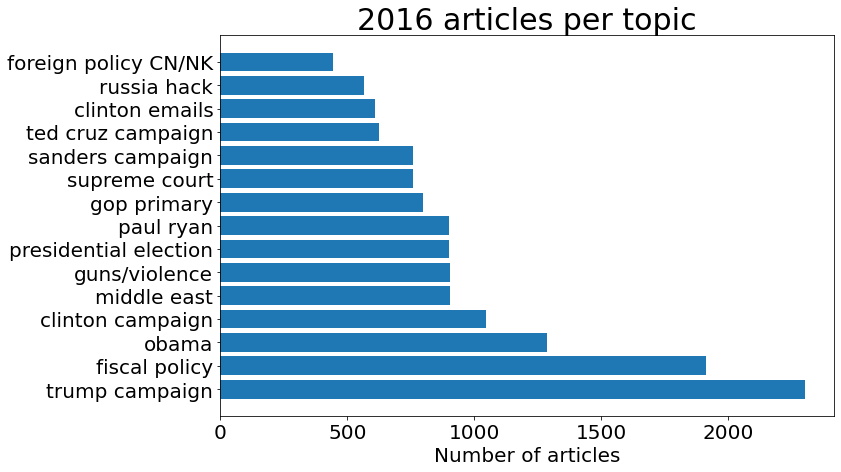

In [341]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2016 articles per topic")
ax.set_xlabel("Number of articles")

ax.barh([topic_dict_2016[i] for i in df_politics_2016.topic.value_counts().index.values], df_politics_2016.topic.value_counts())

We can also look at what fraction of articles fall into each topic based on the publication to see if any publication favors certain topics more than others.

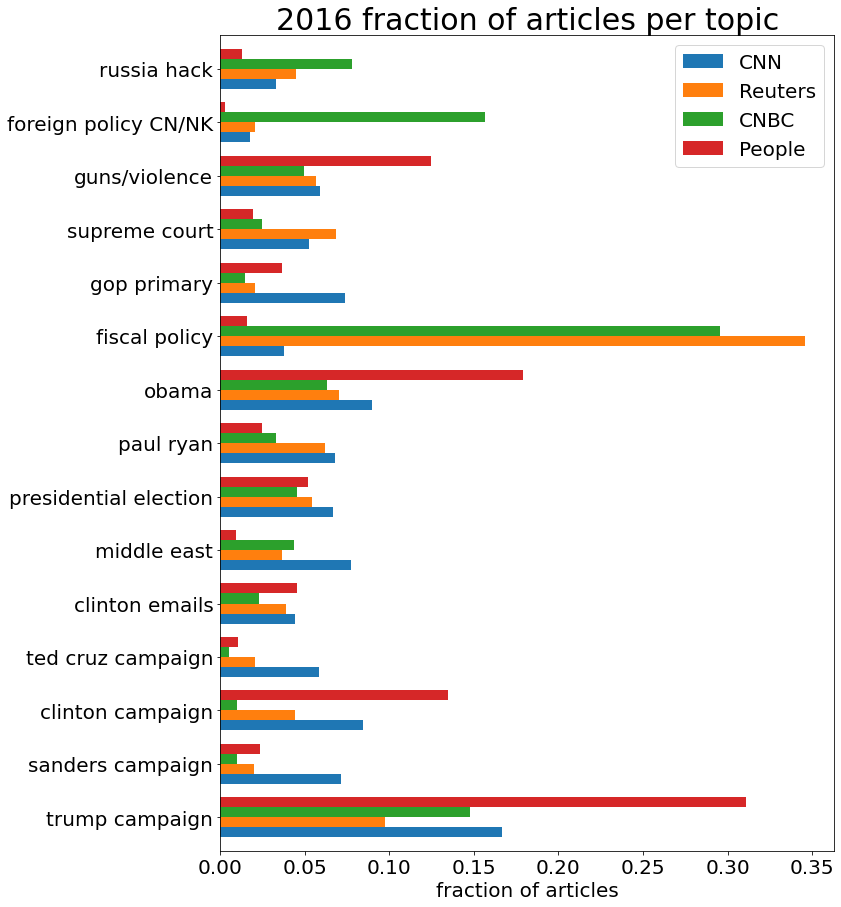

In [342]:
fig, ax = plt.subplots(figsize=(11,15))

ax.set_title("2016 fraction of articles per topic")
ax.set_xlabel("fraction of articles")

cols_to_keep = df_politics_2016.groupby("publication").count().sort_values(by="id", ascending=False).index[:-2]
(df_politics_2016.groupby(["topic", "publication"]).count()["id"].unstack(fill_value=0) / df_politics_2016.groupby(["topic", "publication"]).count()["id"].unstack(fill_value=0).sum())[cols_to_keep].plot(kind="barh", ax=ax,width=0.75)

ax.set_ylabel(None)
ax.set_yticklabels([topic_dict_2016[i] for i in range(15)])
ax.legend(fontsize=20, loc="upper right")

---

# 2018

Let's explore all the politics articles from 2018

In [45]:
df_politics_2018 = None

query = "SELECT * FROM articles WHERE year = 2018 AND section = :sec"

for s in politics_sec.section:
    results = conn.execute(text(query), {"sec": s})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_politics_2018 = pd.concat([df_politics_2018, temp_df])
#conn.close()

In [46]:
df_politics_2018

id                 date  year month day  \
0     10809  2018-01-29 20:50:00  2018     1  29   
1     28720  2018-09-10 18:18:00  2018     9  10   
2     29160  2018-03-13 18:52:00  2018     3  13   
3     31867  2018-02-05 22:00:00  2018     2   5   
4     32906  2018-05-18 20:35:00  2018     5  18   
..      ...                  ...   ...   ...  ..   
55  1679950           2018-08-07  2018     8   7   
56  1679970           2018-08-09  2018     8   9   
57  1680420           2018-08-13  2018     8  13   
58  1680543           2018-08-14  2018     8  14   
59  1680693           2018-08-14  2018     8  14   

                            author  \
0    Caroline Tompkins, Eve Peyser   
1   Elizabeth Renstrom, Eve Peyser   
2                    Marcy Wheeler   
3                       Eve Peyser   
4                       Eve Peyser   
..                             ...   
55                  Tyler McCarthy   
56                 Elizabeth Zwirz   
57                  Tyler McCarthy   
58                  Tyler McCarthy   
59                  Tyler McCarthy   

                                                title  \
0              David Frum Is a Political Party of One   
1   Cynthia Nixon on Her Run for Governor and What...   
2   The Republican Russia Investigation Circus Kee...   
3   Get to Know 'Little' Adam Schiff, Trump's Late...   
4   The Onion’s Brutal Israel Commentary Goes Beyo...   
..                                                ...   
55  'Star Wars' actor Mark Hamill calls for Donald...   
56  Several fake Trump stars reportedly appear on ...   
57  Dwayne 'The Rock' Johnson thanks Sen. Elizabet...   
58  Vincent D'Onofrio polls Twitter followers abou...   
59  Mark Wahlberg's character in 'Mile 22' inspire...   

                                              article  \
0   Though Frum spends his days decrying Donald Tr...   
1   A decade after Nixon's iconic role as Miranda ...   
2   If last week’s Russia investigation-related fi...   
3   I am dying to know how tall Adam Schiff is, bu...   
4   Supporters of Palestinians were outraged. “Eve...   
..                                                ...   
55  \n          Mark Hamill poses with his new Hol...   
56  \n          Several fake stars bearing Donald ...   
57  \n          The Rock and Elizabeth Warren have...   
58  \n          Since posting the tweet on Saturda...   
59  close Video Director Peter Berg on how Steve B...   

                                                  url    section publication  
0   https://www.vice.com/en_us/article/7xeg84/davi...   politics        Vice  
1   https://www.vice.com/en_us/article/wjyqq4/cynt...   politics        Vice  
2   https://www.vice.com/en_us/article/pamjx9/the-...   politics        Vice  
3   https://www.vice.com/en_us/article/7x79zb/get-...   politics        Vice  
4   https://www.vice.com/en_us/article/kzkwzy/the-...   politics        Vice  
..                                                ...        ...         ...  
55  https://www.foxnews.com/entertainment/star-war...  Political    Fox News  
56  https://www.foxnews.com/entertainment/several-...  Political    Fox News  
57  https://www.foxnews.com/entertainment/dwayne-t...  Political    Fox News  
58  https://www.foxnews.com/entertainment/vincent-...  Political    Fox News  
59  https://www.foxnews.com/entertainment/mark-wah...  Political    Fox News  

[23607 rows x 11 columns]

---

 Most of them are from CNN

<BarContainer object of 8 artists>

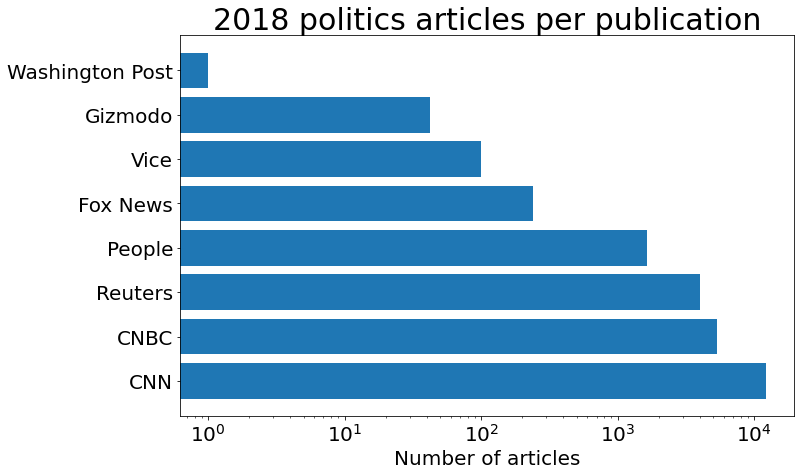

In [47]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2018 politics articles per publication")
ax.set_xlabel("Number of articles")

ax.barh(df_politics_2018.groupby("publication").count().sort_values(by="id", ascending=False).index, width=df_politics_2018.groupby("publication").count().sort_values(by="id", ascending=False)["id"], log=True)

---

# Preprocessing

Same preprocessing as before: drop articles that are empty or only contain a space.

In [48]:
(df_politics_2018.article == "").value_counts()

False    23602
True         5
Name: article, dtype: int64

In [49]:
articles_to_drop = df_politics_2018[df_politics_2018.article == ""]
articles_to_drop

id        date  year month day author  \
10016  973872  2018-08-22  2018     8  22          
10803  978034  2018-09-18  2018     9  18          
10988  978955  2018-09-24  2018     9  24          
12808  990431  2018-11-18  2018    11  18          
13728  996675  2018-12-19  2018    12  19          

                                                 title article  \
10016                       The Cohen-Manafort fallout           
10803                                            Error           
10988  Latest news: Rod Rosenstein expects to be fired           
12808                                            Error           
13728                                            Error           

                                                     url   section publication  
10016  https://www.cnn.com/2018/08/22/politics/manafo...  politics         CNN  
10803  https://www.cnn.com/2018/09/18/politics/kavana...  politics         CNN  
10988  https://www.cnn.com/2018/09/24/politics/rod-ro...  politics         CNN  
12808  https://www.cnn.com/2018/11/18/politics/young-...  politics         CNN  
13728  https://www.cnn.com/2018/12/19/politics/europe...  politics         CNN

In [50]:
df_politics_2018.drop(articles_to_drop.index, inplace=True)
df_politics_2018.reset_index(drop=True, inplace=True)
(df_politics_2018.article == "").value_counts()

False    23602
Name: article, dtype: int64

---

In [51]:
(df_politics_2018.article == " ").value_counts()

False    23546
True        56
Name: article, dtype: int64

In [52]:
articles_to_drop = df_politics_2018[df_politics_2018.article == " "]
articles_to_drop.head()

id        date  year month day          author  \
1768  944814  2018-01-02  2018     1   2      Meg Wagner   
1816  945016  2018-01-03  2018     1   3  Veronica Rocha   
1941  945582  2018-01-08  2018     1   8      Meg Wagner   
1942  945584  2018-01-08  2018     1   8      Meg Wagner   
2022  945916  2018-01-09  2018     1   9      Meg Wagner   

                                            title article  \
1768              Today in politics: Live updates           
1816     White House press briefing: Live updates           
1941          President Trump today: Live updates           
1942                     Oprah 2020: Live updates           
2022  It's a big day for immigration: Follow live           

                                                    url   section publication  
1768  https://www.cnn.com/2018/01/02/politics/trump-...  politics         CNN  
1816  https://www.cnn.com/2018/01/03/politics/trump-...  politics         CNN  
1941  https://www.cnn.com/2018/01/08/politics/trump-...  politics         CNN  
1942  https://www.cnn.com/2018/01/08/politics/oprah-...  politics         CNN  
2022  https://www.cnn.com/2018/01/09/politics/trump-...  politics         CNN

In [55]:
df_politics_2018.drop(articles_to_drop.index, inplace=True)
df_politics_2018.reset_index(drop=True, inplace=True)
(df_politics_2018.article == " ").value_counts()

False    23434
Name: article, dtype: int64

---

Most articles are about the same length but there are a few extremely long ones and extremely short.

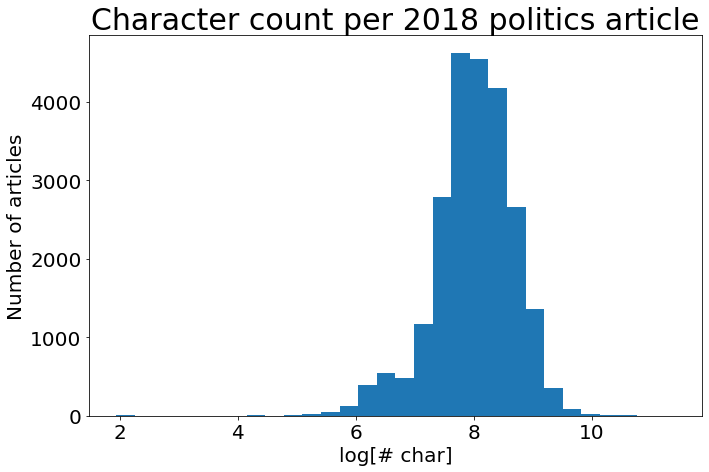

In [56]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2018 politics article")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

ax.hist(np.log(df_politics_2018.article.str.len()), bins=30);

In [57]:
article_lengths = df_politics_2018.article.str.len().sort_values()
article_lengths

10814        7
4641         7
13603        7
3595         7
4299         7
         ...  
21158    46656
8785     52341
11906    55859
10935    87399
3599     89310
Name: article, Length: 23434, dtype: int64

---

The long ones seem to correspond to speech transcripts.

In [58]:
df_politics_2018.iloc[article_lengths.index[-5:]]

id                 date  year month day          author  \
21158  1561529  2018-08-29 00:00:00  2018     8  29                   
8785    968146           2018-07-17  2018     7  17                   
11906   985621           2018-10-26  2018    10  26  Marshall Cohen   
10935   979435           2018-09-27  2018     9  27                   
3599    953664           2018-02-22  2018     2  22                   

                                                   title  \
21158  How the Trump administration went easy on smal...   
8785   Transcript: Obama's full speech about the 'pol...   
11906                       48 hours fact checking Trump   
10935                  Trump White House transcript test   
3599   CNN town hall: Students question lawmakers, NR...   

                                                 article  \
21158  On a chilly morning in December 2016, 12-year-...   
8785    (CNN)Former President Barack Obama spoke in J...   
11906   As the midterm elections draw closer, Preside...   
10935  Transcript of President Trump's press conferen...   
3599    (CNN)Survivors of the massacre at Stoneman Do...   

                                                     url   section publication  
21158  https://www.cnbc.com/2018/08/29/how-the-trump-...  Politics        CNBC  
8785   https://www.cnn.com/2018/07/17/politics/barack...  politics         CNN  
11906  https://www.cnn.com/2018/10/26/politics/trump-...  politics         CNN  
10935  https://www.cnn.com/2018/09/27/politics/transc...  politics         CNN  
3599   https://www.cnn.com/2018/02/22/politics/cnn-to...  politics         CNN

---

The short ones seem to be corrupted.

In [59]:
df_politics_2018.iloc[article_lengths.index[:5]]

id        date  year month day author  \
10814  978904  2018-09-24  2018     9  24          
4641   956977  2018-03-21  2018     3  21          
13603  997041  2018-12-20  2018    12  20          
3595   953648  2018-02-22  2018     2  22          
4299   956182  2018-03-12  2018     3  12          

                                                   title  article  \
10814  READ: Brett Kavanaugh defends himself in lette...   (CNN)    
4641           Read the 2,232-page omnibus spending bill   (CNN)    
13603  READ: New continuing resolution bill heading t...   (CNN)    
3595   Read the new indictment of Paul Manafort and R...   (CNN)    
4299   READ: 1-page summary of initial Republican fin...   (CNN)    

                                                     url   section publication  
10814  https://www.cnn.com/2018/09/24/politics/read-b...  politics         CNN  
4641   https://www.cnn.com/2018/03/21/politics/omnibu...  politics         CNN  
13603  https://www.cnn.com/2018/12/20/politics/new-co...  politics         CNN  
3595   https://www.cnn.com/2018/02/22/politics/manafo...  politics         CNN  
4299   https://www.cnn.com/2018/03/12/politics/gop-fi...  politics         CNN

---

Based on the above distribution of article lengths, we can assume that articles with $\le e^6$ characters ($\approx 80$ words) are likely corrupted or too short and will be dropped.

In [60]:
df_politics_2018 = df_politics_2018[df_politics_2018.article.str.len() > int(np.exp(6))]
df_politics_2018.reset_index(drop=True, inplace=True)

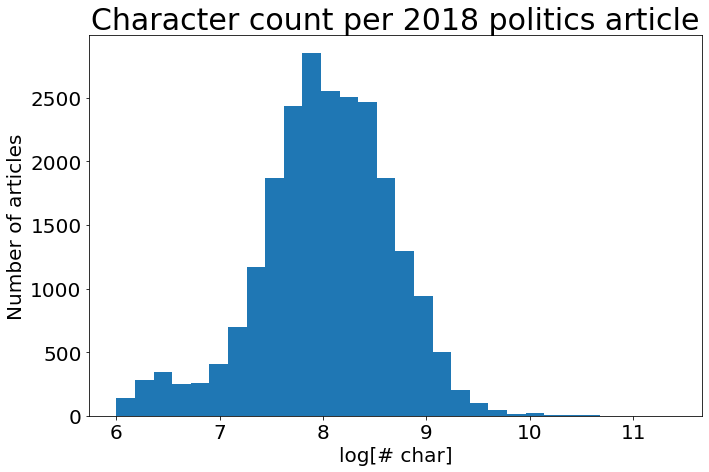

In [61]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2018 politics article")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

plt.hist(np.log(df_politics_2018.article.str.len()), bins=30);

---

The final number of articles is 23241

In [62]:
len(df_politics_2018)

23241

---

Finally, it's important that all the words are lowercase so they can be matched to stop words and with each other.

In [63]:
df_politics_2018.article = df_politics_2018.article.str.lower()
df_politics_2018.head()

/tmp/ipykernel_707/1239745080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_politics_2018.article = df_politics_2018.article.str.lower()


id                 date  year month day                          author  \
0  10809  2018-01-29 20:50:00  2018     1  29   Caroline Tompkins, Eve Peyser   
1  28720  2018-09-10 18:18:00  2018     9  10  Elizabeth Renstrom, Eve Peyser   
2  29160  2018-03-13 18:52:00  2018     3  13                   Marcy Wheeler   
3  31867  2018-02-05 22:00:00  2018     2   5                      Eve Peyser   
4  32906  2018-05-18 20:35:00  2018     5  18                      Eve Peyser   

                                               title  \
0             David Frum Is a Political Party of One   
1  Cynthia Nixon on Her Run for Governor and What...   
2  The Republican Russia Investigation Circus Kee...   
3  Get to Know 'Little' Adam Schiff, Trump's Late...   
4  The Onion’s Brutal Israel Commentary Goes Beyo...   

                                             article  \
0  though frum spends his days decrying donald tr...   
1  a decade after nixon's iconic role as miranda ...   
2  if last week’s russia investigation-related fi...   
3  i am dying to know how tall adam schiff is, bu...   
4  supporters of palestinians were outraged. “eve...   

                                                 url   section publication  
0  https://www.vice.com/en_us/article/7xeg84/davi...  politics        Vice  
1  https://www.vice.com/en_us/article/wjyqq4/cynt...  politics        Vice  
2  https://www.vice.com/en_us/article/pamjx9/the-...  politics        Vice  
3  https://www.vice.com/en_us/article/7x79zb/get-...  politics        Vice  
4  https://www.vice.com/en_us/article/kzkwzy/the-...  politics        Vice

---

In [64]:
tfidf_text_2018 = TfidfVectorizer(tokenizer=spacy_tokenizer, min_df=5, max_df=0.7)
vectors_text_2018 = tfidf_text_2018.fit_transform(df_politics_2018["article"])

# NMF

In [65]:
nmf_text_model_2018 = NMF(n_components=15, random_state=43, alpha_W=0.0, alpha_H="same")
W_text_matrix_2018 = nmf_text_model_2018.fit_transform(vectors_text_2018)
H_text_matrix_2018 = nmf_text_model_2018.components_

In [106]:
df_politics_2018["topic"] = np.argmax(W_text_matrix_2018, axis=1)

/tmp/ipykernel_707/1429781478.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_politics_2018["topic"] = np.argmax(W_text_matrix_2018, axis=1)


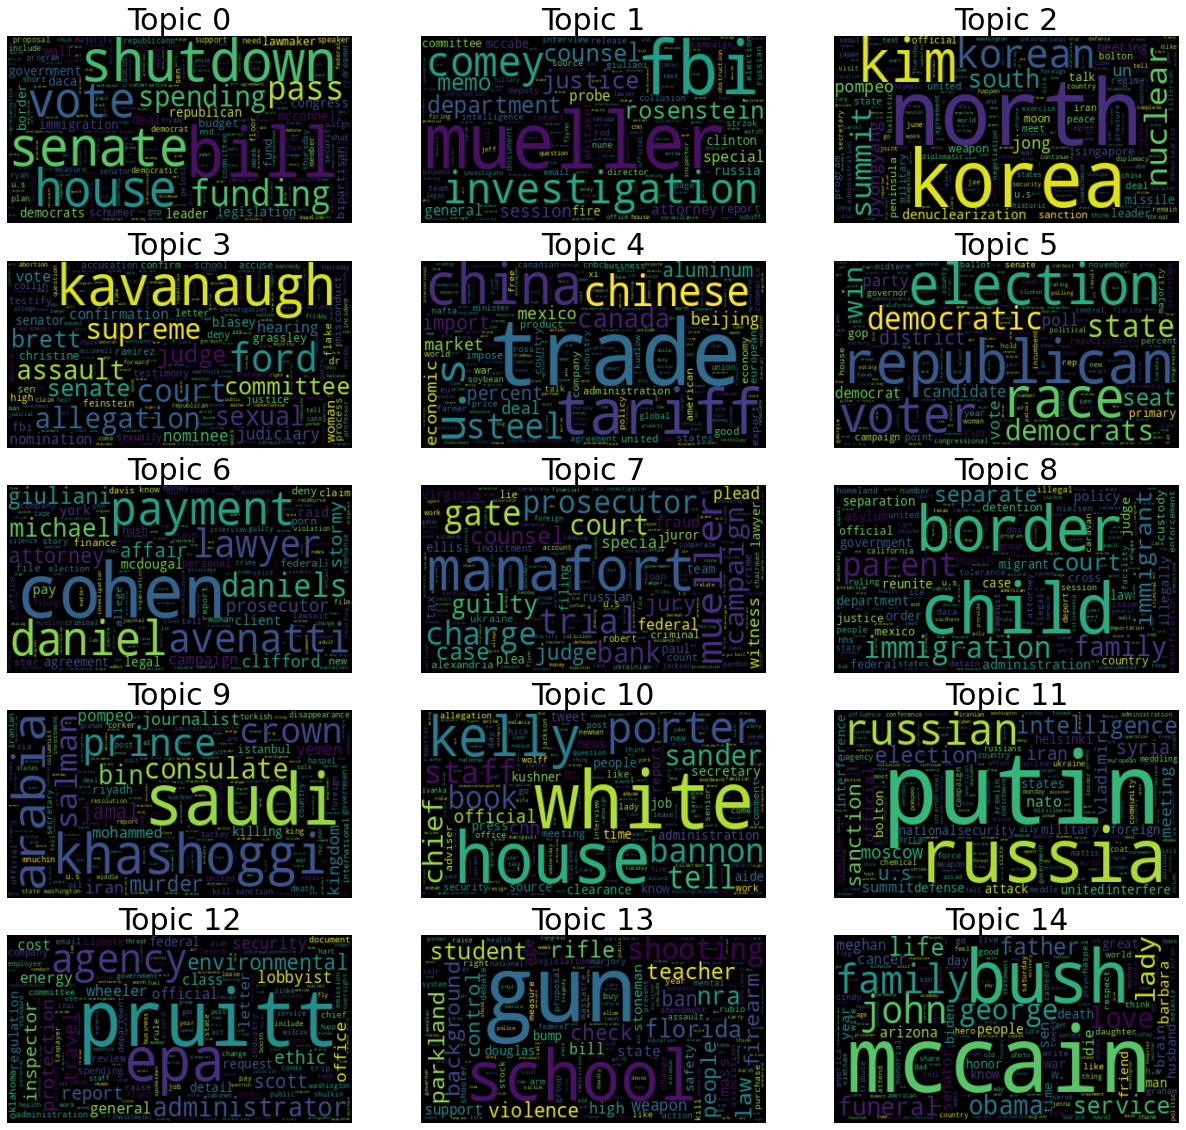

In [270]:
fig, axs = plt.subplots(5,3, figsize=(21,20))

words = tfidf_text_2018.get_feature_names_out()
for topic, weights in enumerate(H_text_matrix_2018):
        largest = weights.argsort()[::-1]
        d = {}
        for i in range(200):
            d[words[largest[i]]] = weights[largest[i]]

        wocl = WordCloud()
        wocl.generate_from_frequencies(d)
        
        axs[topic//3, topic%3].set_title("Topic %d" % topic)
        axs[topic//3, topic%3].imshow(wocl, aspect='auto', interpolation='bilinear')
        axs[topic//3, topic%3].axis("off")

In [269]:
#display_topics(nmf_text_model_2018, tfidf_text_2018.get_feature_names_out())

In [274]:
df_politics_2018.groupby("topic").sample(3, random_state=234)

id                 date  year month day                   author  \
2524    948379           2018-01-23  2018     1  23           Maegan Vazquez   
5607    959217           2018-04-18  2018     4  18           Sunlen Serfaty   
2342    947490           2018-01-18  2018     1  18          Brenna Williams   
4944    957721           2018-03-30  2018     3  30                Manu Raju   
14673    80534  2018-04-16 00:00:00  2018     4  16                            
2047    946137           2018-01-11  2018     1  11  By Katelyn Polantz, CNN   
22872  1547384           2018-06-14  2018     6  14                            
16934  1181824           2018-06-07  2018     6   7                            
19125  1535181           2018-04-18  2018     4  18                            
14445    59439  2018-09-28 00:00:00  2018     9  28                            
14195    40127  2018-09-28 00:00:00  2018     9  28                            
23015  1668313  2018-06-08 00:00:00  2018     6   8           Benjamin Brown   
19759  1544357           2018-05-31  2018     5  31                            
23146  1545812           2018-06-06  2018     6   6                            
11362   982535           2018-10-11  2018    10  11          Nicole Gaouette   
9417    971656           2018-08-07  2018     8   7            Gregory Krieg   
20429  1552563           2018-08-05  2018     8   5          John Whitesides   
14579    70879  2018-10-16 00:00:00  2018    10  16           James Oliphant   
14608    73483  2018-08-21 00:00:00  2018     8  21                            
20903  1560399  2018-08-22 00:00:00  2018     8  22                            
19543  1541444           2018-05-16  2018     5  16                            
9415    971645           2018-08-07  2018     8   7        Stephen Collinson   
14249    44371  2018-04-20 00:00:00  2018     4  20             Steve Gorman   
9690    973220           2018-08-17  2018     8  17          Katelyn Polantz   
7727    964050           2018-06-18  2018     6  18                Tal Kopan   
4915    957644           2018-03-29  2018     3  29                Tal Kopan   
9110    969918           2018-07-27  2018     7  27    Catherine E. Shoichet   
4689    957116           2018-03-22  2018     3  22               Dan Merica   
12688   991180           2018-11-21  2018    11  21          Nicole Gaouette   
16185   578845  2018-04-26 00:00:00  2018     4  26                            
13156   994568           2018-12-07  2018    12   7               Evan Perez   
20407  1552341           2018-06-20  2018     6  20                            
23187  1666128  2018-05-09 00:00:00  2018     5   9           Tyler McCarthy   
4610    956959           2018-03-21  2018     3  21           Chris Cillizza   
22777  1559652           2018-08-19  2018     8  19                            
7391    963325           2018-06-08  2018     6   8             Kevin Liptak   
17212  1289197           2018-11-20  2018    11  20          Jarrett Renshaw   
6260    960794           2018-05-07  2018     5   7               Sara Ganim   
18583  1528293           2018-03-16  2018     3  16                            
18211  1523252           2018-02-20  2018     2  20                            
10476   977363           2018-09-13  2018     9  13           Sunlen Serfaty   
12699   991338           2018-11-22  2018    11  22              Harry Enten   
1004    712871  2018-05-16 10:31:00  2018     5  16           Tierney McAfee   
1944    945659           2018-01-08  2018     1   8          Ashley Killough   
14568    70243  2018-08-26 00:00:00  2018     8  26                            

                                                   title  \
2524   OMB director: Trump's position on Dreamers 'de...   
5607   Democratic male senators push to advance sexua...   
2342       #TBT: Memorable quotes from the 2013 shutdown   
4944   Internal FBI report shows discrepancy between ...   
14673  Trump, Republicans inten

In [69]:
topic_dict_2018 = {
    0:  "government shutdown",
    1:  "mueller investigation",
    2:  "nuclear summit",
    3:  "kavanaugh",
    4:  "china tariffs",
    5:  "election",
    6:  "stormy daniels",
    7:  "manafort",
    8:  "immigration policy",
    9:  "khashoggi assassination",
    10: "trump cabinet",
    11: "russia sanction",
    12: "epa",
    13: "parkland shooting",
    14: "mccain passing"
}

<BarContainer object of 15 artists>

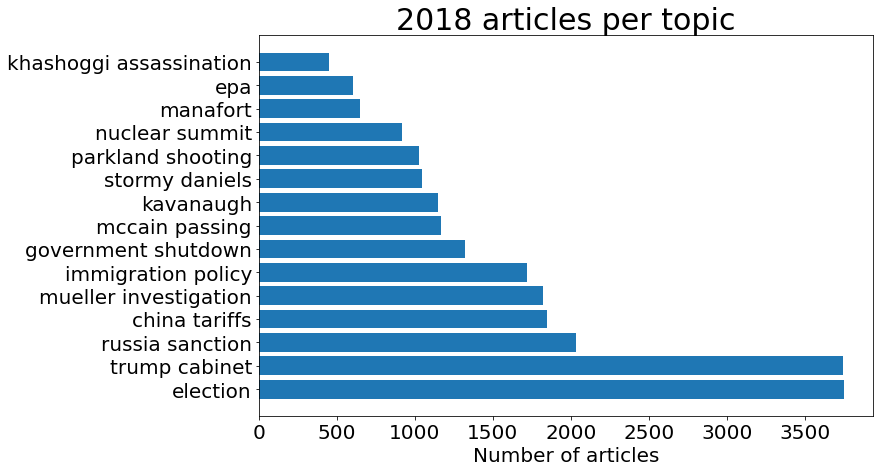

In [70]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2018 articles per topic")
ax.set_xlabel("Number of articles")

ax.barh([topic_dict_2018[i] for i in df_politics_2018.topic.value_counts().index.values], df_politics_2018.topic.value_counts())

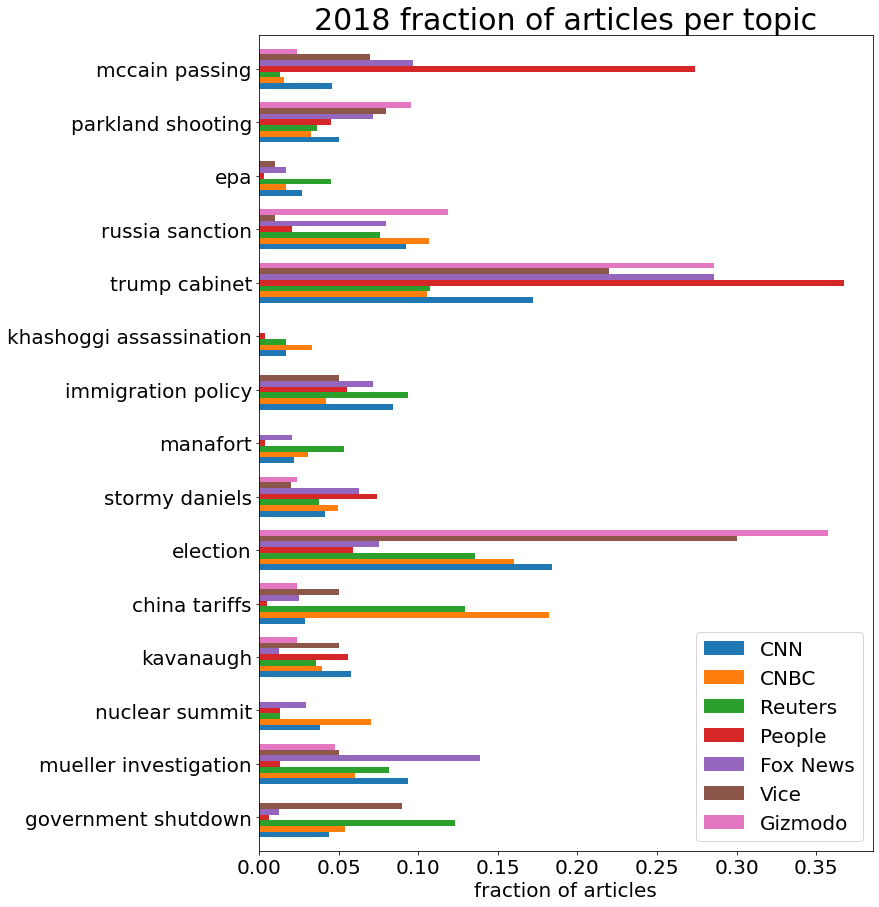

In [256]:
fig, ax = plt.subplots(figsize=(11,15))

ax.set_title("2018 fraction of articles per topic")
ax.set_xlabel("fraction of articles")

cols_to_keep = df_politics_2018.groupby("publication").count().sort_values(by="id", ascending=False).index[:-1]
(df_politics_2018.groupby(["topic", "publication"]).count()["id"].unstack(fill_value=0) / df_politics_2018.groupby(["topic", "publication"]).count()["id"].unstack(fill_value=0).sum())[cols_to_keep].plot(kind="barh", ax=ax,width=0.75)

ax.set_ylabel(None)
ax.set_yticklabels([topic_dict_2018[i] for i in range(15)])
ax.legend(fontsize=20, loc="lower right")

---

# 2020

Let's explore all the politics articles from 2020

In [71]:
df_politics_2020 = None

query = "SELECT * FROM articles WHERE year = 2020 AND section = :sec"

for s in politics_sec.section:
    results = conn.execute(text(query), {"sec": s})
    temp_df = pd.DataFrame(results.fetchall(), columns = results.keys())
    
    df_politics_2020 = pd.concat([df_politics_2020, temp_df])
#conn.close()

In [72]:
df_politics_2020

id                 date  year month day             author  \
0   2604434  2020-01-01 00:00:00  2020     1   1        Harry Enten   
1   2604458  2020-01-01 00:00:00  2020     1   1       Kevin Liptak   
2   2604476  2020-01-01 00:00:00  2020     1   1       Kevin Liptak   
3   2604515  2020-01-01 00:00:00  2020     1   1  Fredreka Schouten   
4   2604550  2020-01-01 00:00:00  2020     1   1  Stephen Collinson   
..      ...                  ...   ...   ...  ..                ...   
35  2738949  2020-03-14 00:00:00  2020     3  14                      
36  2757221  2020-03-19 00:00:00  2020     3  19                      
37  2757410  2020-03-20 00:00:00  2020     3  20                      
38  2757534  2020-03-21 00:00:00  2020     3  21                      
39  2783630  2020-03-28 00:00:00  2020     3  28                      

                                                title  \
0   Donald Trump: White Evangelicals love him. Rel...   
1           How the Trumps spent their New Year's Eve   
2   Davos: White House official says Trump expecte...   
3   Pete Buttigieg announces $24.7 million fundrai...   
4   Twin foreign policy crises greet Trump as elec...   
..                                                ...   
35  Op-Ed: The US should call NATO to action and d...   
36  Op-Ed: As coronavirus crisis grows, Trump must...   
37  Op-Ed: Lawmakers must fix another looming econ...   
38  Op-Ed: The US should rally G7, NATO and other ...   
39  Op-Ed: Coronavirus will hit emerging markets w...   

                                              article  \
0    (CNN)Much has been made of President Donald T...   
1   PALM BEACH, Florida (CNN)Sequins and Benghazi....   
2    (CNN)President Donald Trump is expected to go...   
3    (CNN)Pete Buttigieg raised more than $24.7 mi...   
4    (CNN)President Donald Trump is suddenly faced...   
..                                                ...   
35  While listening to President Trump announce th...   
36  The COVID-19 pandemic is a matter of life and ...   
37  For the first time in over a century, a global...   
38  The latest plot twist is a stunner in our ongo...   
39  With apologies to the great hockey player Wayn...   

                                                  url             section  \
0   https://www.cnn.com/2020/01/01/politics/evange...            politics   
1   https://www.cnn.com/2020/01/01/politics/trump-...            politics   
2   https://www.cnn.com/2020/01/01/politics/trump-...            politics   
3   https://www.cnn.com/2020/01/01/politics/pete-b...            politics   
4   https://www.cnn.com/2020/01/01/politics/donald...            politics   
..                                                ...                 ...   
35  https://www.cnbc.com/2020/03/14/op-ed-the-us-s...  Opinion - Politics   
36  https://www.cnbc.com/2020/03/19/op-ed-as-coron...  Opinion - Politics   
37  https://www.cnbc.com/2020/03/20/op-ed-lawmaker...  Opinion - Politics   
38  https://www.cnbc.com/2020/03/21/op-ed-the-us-s...  Opinion - Politics   
39  https://www.cnbc.com/2020/03/27/op-ed-coronavi...  Opinion - Politics   

   publication  
0          CNN  
1          CNN  
2          CNN  
3          CNN  
4          CNN  
..         ...  
35        CNBC  
36        CNBC  
37        CNBC  
38        CNBC  
39        CNBC  

[5556 rows x 11 columns]

---

 Most of them are from CNN

<BarContainer object of 4 artists>

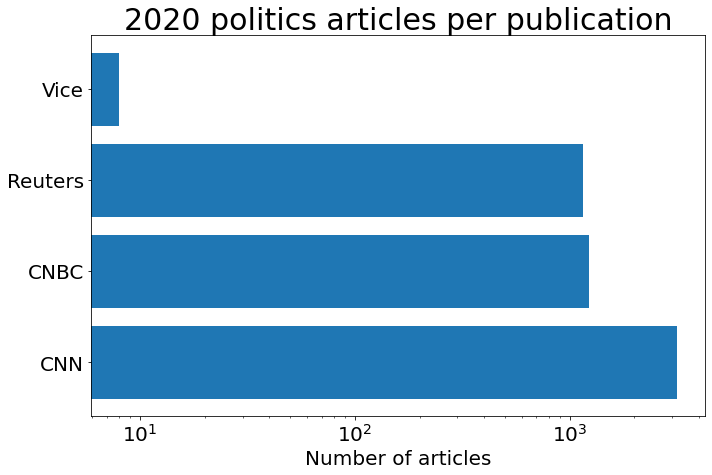

In [73]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2020 politics articles per publication")
ax.set_xlabel("Number of articles")

ax.barh(df_politics_2020.groupby("publication").count().sort_values(by="id", ascending=False).index, width=df_politics_2020.groupby("publication").count().sort_values(by="id", ascending=False)["id"], log=True)

---

# Preprocessing

There are a few articles that are empty and will need to be dropped.

In [74]:
(df_politics_2020.article == "").value_counts()

False    5555
True        1
Name: article, dtype: int64

In [75]:
articles_to_drop = df_politics_2020[df_politics_2020.article == ""]
articles_to_drop

id                 date  year month day author  \
1043  2610612  2020-01-31 00:00:00  2020     1  31          

                                                  title article  \
1043  Hamburg, Iowa: The impact of the climate crisi...           

                                                    url   section publication  
1043  https://www.cnn.com/2020/01/31/politics/climat...  politics         CNN

In [76]:
df_politics_2020.drop(articles_to_drop.index, inplace=True)
df_politics_2020.reset_index(drop=True, inplace=True)
(df_politics_2020.article == "").value_counts()

False    5554
Name: article, dtype: int64

---

There are also articles that only contain a space and will need to be dropped.

In [77]:
(df_politics_2020.article == " ").value_counts()

False    5552
True        2
Name: article, dtype: int64

In [78]:
articles_to_drop = df_politics_2020[df_politics_2020.article == " "]
articles_to_drop.head()

id                 date  year month day author  \
3129  2779555  2020-03-30 00:00:00  2020     3  30          
3134  2779577  2020-03-30 00:00:00  2020     3  30          

                                                  title article  \
3129  Have questions about how COVID-19 affects poli...           
3134  Have questions about how COVID-19 affects poli...           

                                                    url   section publication  
3129  https://www.cnn.com/2020/03/30/politics/daily-...  politics         CNN  
3134  https://www.cnn.com/2020/03/30/politics/daily-...  politics         CNN

In [79]:
df_politics_2020.drop(articles_to_drop.index, inplace=True)
df_politics_2020.reset_index(drop=True, inplace=True)
(df_politics_2020.article == " ").value_counts()

False    5552
Name: article, dtype: int64

---

Most articles are about the same length but there are a few extremely long ones and extremely short.

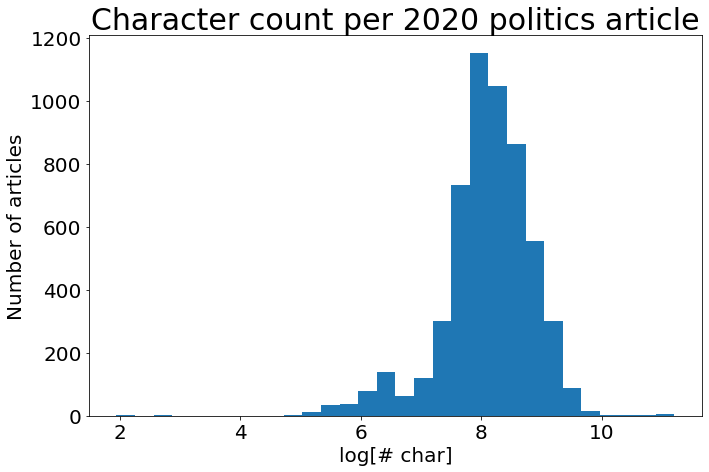

In [80]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2020 politics article")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

ax.hist(np.log(df_politics_2020.article.str.len()), bins=30);

In [81]:
article_lengths = df_politics_2020.article.str.len().sort_values()
article_lengths

630         7
1267        7
127        17
2188      113
648       150
        ...  
2386    57779
1799    59995
562     60972
1571    64408
70      73716
Name: article, Length: 5552, dtype: int64

---

The long ones seem to correspond to debate transcripts.

In [82]:
df_politics_2020.iloc[article_lengths.index[-5:]]

id                 date  year month day       author  \
2386  2775112  2020-03-09 00:00:00  2020     3   9  Daniel Dale   
1799  2680015  2020-02-22 00:00:00  2020     2  22  Daniel Dale   
562   2607638  2020-01-19 00:00:00  2020     1  19  Daniel Dale   
1571  2678487  2020-02-14 00:00:00  2020     2  14  Daniel Dale   
70    2605252  2020-01-04 00:00:00  2020     1   4  Daniel Dale   

                                                  title  \
2386  Fact check: Donald Trump made 115 false claims...   
1799  Trump made 56 false claims last week, includin...   
562   Fact check: Trump reverts to his usual dishone...   
1571  Fact check: Trump makes 86 false claims over t...   
70              Fact check: Trump made 40 false claims    

                                                article  \
2386  Washington (CNN)President Donald Trump made 11...   
1799  Washington (CNN)President Donald Trump made 56...   
562   Washington (CNN)President Donald Trump made ju...   
1571  Washington (CNN)President Donald Trump made 31...   
70    Washington (CNN)President Donald Trump's final...   

                                                    url   section publication  
2386  https://www.cnn.com/2020/03/09/politics/fact-c...  politics         CNN  
1799  https://www.cnn.com/2020/02/22/politics/fact-c...  politics         CNN  
562   https://www.cnn.com/2020/01/19/politics/fact-c...  politics         CNN  
1571  https://www.cnn.com/2020/02/14/politics/fact-c...  politics         CNN  
70    https://www.cnn.com/2020/01/04/politics/trump-...  politics         CNN

---

The short ones seem to be corrupted.

In [83]:
df_politics_2020.iloc[article_lengths.index[:5]]

id                 date  year month day     author  \
630   2608052  2020-01-21 00:00:00  2020     1  21              
1267  2677201  2020-02-07 00:00:00  2020     2   7  Adam Levy   
127   2605465  2020-01-06 00:00:00  2020     1   6        CNN   
2188  2774514  2020-03-03 00:00:00  2020     3   3              
648   2608146  2020-01-21 00:00:00  2020     1  21              

                                                  title  \
630   READ: Schumer introduces amendment on subpoena...   
1267      Iowa recanvass and recount: Read the manual     
127   READ: Schumer, Menendez letter calling on WH t...   
2188  READ: White House questionnaire asks which par...   
648   READ: Schumer introduces amendment to subpoena...   

                                                article  \
630                                              (CNN)    
1267                                             (CNN)    
127                                   Washington (CNN)    
2188  CNN (CNN)Read the new White House questionnair...   
648    (CNN)Senate Minority Leader Chuck Schumer int...   

                                                    url   section publication  
630   https://www.cnn.com/2020/01/21/politics/schume...  politics         CNN  
1267  https://www.cnn.com/2020/02/07/politics/iowa-r...  politics         CNN  
127   https://www.cnn.com/2020/01/06/politics/schume...  politics         CNN  
2188  https://www.cnn.com/2020/03/03/politics/white-...  politics         CNN  
648   https://www.cnn.com/2020/01/21/politics/schume...  politics         CNN

---

Based on the above distribution of article lengths, we can assume that articles with $\le e^6$ characters ($\approx 80$ words) are likely corrupted or too short and will be dropped.

In [84]:
df_politics_2020 = df_politics_2020[df_politics_2020.article.str.len() > int(np.exp(6))]
df_politics_2020.reset_index(drop=True, inplace=True)

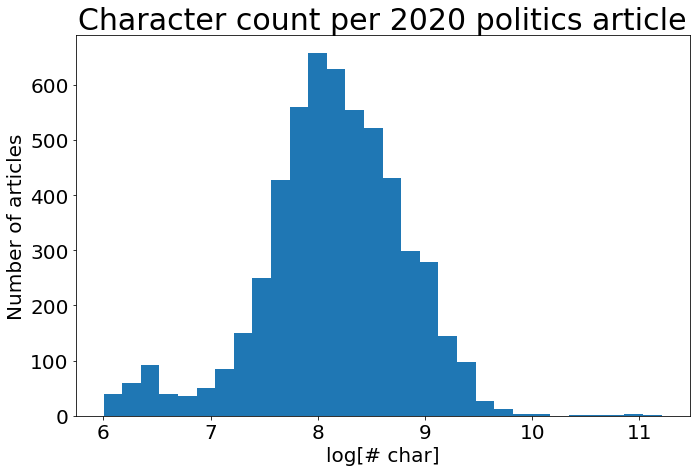

In [85]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("Character count per 2020 politics article")
ax.set_xlabel("log[# char]")
ax.set_ylabel("Number of articles")

plt.hist(np.log(df_politics_2020.article.str.len()), bins=30);

---

The final number of articles is 5456

In [86]:
len(df_politics_2020)

5456

---

Finally, it's important that all the words are lowercase so they can be matched to stop words and with each other.

In [87]:
df_politics_2020.article = df_politics_2020.article.str.lower()
df_politics_2020.head()

/tmp/ipykernel_707/2787701250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_politics_2020.article = df_politics_2020.article.str.lower()


id                 date  year month day             author  \
0  2604434  2020-01-01 00:00:00  2020     1   1        Harry Enten   
1  2604458  2020-01-01 00:00:00  2020     1   1       Kevin Liptak   
2  2604476  2020-01-01 00:00:00  2020     1   1       Kevin Liptak   
3  2604515  2020-01-01 00:00:00  2020     1   1  Fredreka Schouten   
4  2604550  2020-01-01 00:00:00  2020     1   1  Stephen Collinson   

                                               title  \
0  Donald Trump: White Evangelicals love him. Rel...   
1          How the Trumps spent their New Year's Eve   
2  Davos: White House official says Trump expecte...   
3  Pete Buttigieg announces $24.7 million fundrai...   
4  Twin foreign policy crises greet Trump as elec...   

                                             article  \
0   (cnn)much has been made of president donald t...   
1  palm beach, florida (cnn)sequins and benghazi....   
2   (cnn)president donald trump is expected to go...   
3   (cnn)pete buttigieg raised more than $24.7 mi...   
4   (cnn)president donald trump is suddenly faced...   

                                                 url   section publication  
0  https://www.cnn.com/2020/01/01/politics/evange...  politics         CNN  
1  https://www.cnn.com/2020/01/01/politics/trump-...  politics         CNN  
2  https://www.cnn.com/2020/01/01/politics/trump-...  politics         CNN  
3  https://www.cnn.com/2020/01/01/politics/pete-b...  politics         CNN  
4  https://www.cnn.com/2020/01/01/politics/donald...  politics         CNN

---

In [89]:
tfidf_text_2020 = TfidfVectorizer(tokenizer=spacy_tokenizer, min_df=5, max_df=0.7)
vectors_text_2020 = tfidf_text_2020.fit_transform(df_politics_2020["article"])

# NMF

In [94]:
nmf_text_model_2020 = NMF(n_components=15, random_state=43, alpha_W=0.0, alpha_H="same", max_iter=1000)
W_text_matrix_2020 = nmf_text_model_2020.fit_transform(vectors_text_2020)
H_text_matrix_2020 = nmf_text_model_2020.components_

In [103]:
df_politics_2020["topic"] = np.argmax(W_text_matrix_2020, axis=1)

/tmp/ipykernel_707/1433971834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_politics_2020["topic"] = np.argmax(W_text_matrix_2020, axis=1)


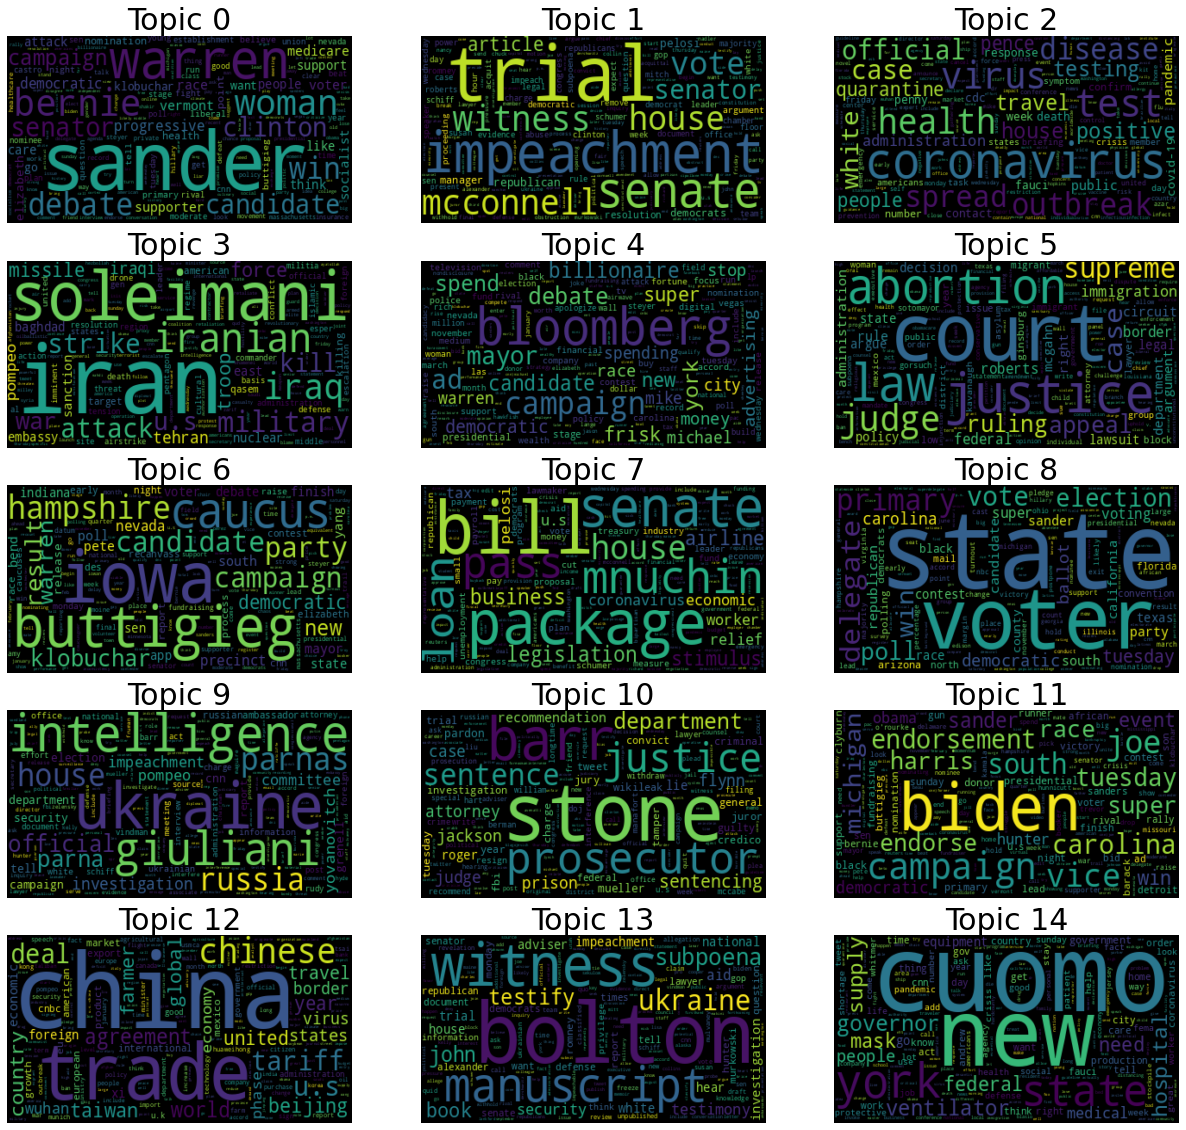

In [272]:
fig, axs = plt.subplots(5,3, figsize=(21,20))

words = tfidf_text_2020.get_feature_names_out()
for topic, weights in enumerate(H_text_matrix_2020):
        largest = weights.argsort()[::-1]
        d = {}
        for i in range(200):
            d[words[largest[i]]] = weights[largest[i]]

        wocl = WordCloud()
        wocl.generate_from_frequencies(d)
        
        axs[topic//3, topic%3].set_title("Topic %d" % topic)
        axs[topic//3, topic%3].imshow(wocl, aspect='auto', interpolation='bilinear')
        axs[topic//3, topic%3].axis("off")

In [271]:
#display_topics(nmf_text_model_2020, tfidf_text_2020.get_feature_names_out())

In [273]:
df_politics_2020.groupby("topic").sample(3, random_state=234)

id                 date  year month day  \
403   2606572  2020-01-15 00:00:00  2020     1  15   
4326  2691965  2020-02-23 00:00:00  2020     2  23   
4650  2716975  2020-03-06 00:00:00  2020     3   6   
409   2606610  2020-01-15 00:00:00  2020     1  15   
910   2610020  2020-01-29 00:00:00  2020     1  29   
996   2610527  2020-01-31 00:00:00  2020     1  31   
4470  2702679  2020-02-29 00:00:00  2020     2  29   
5039  2757585  2020-03-22 00:00:00  2020     3  22   
5016  2757346  2020-03-19 00:00:00  2020     3  19   
481   2607186  2020-01-17 00:00:00  2020     1  17   
159   2605594  2020-01-07 00:00:00  2020     1   7   
41    2605063  2020-01-03 00:00:00  2020     1   3   
3893  2636437  2020-02-07 00:00:00  2020     2   7   
4102  2654506  2020-02-11 00:00:00  2020     2  11   
124   2605445  2020-01-06 00:00:00  2020     1   6   
355   2606295  2020-01-13 00:00:00  2020     1  13   
4049  2651110  2020-02-13 00:00:00  2020     2  13   
3122  2555651  2020-01-03 00:00:00  2020     1   3   
560   2607701  2020-01-19 00:00:00  2020     1  19   
3931  2638250  2020-02-08 00:00:00  2020     2   8   
4218  2666125  2020-02-17 00:00:00  2020     2  17   
4504  2708439  2020-03-04 00:00:00  2020     3   4   
5022  2757377  2020-03-20 00:00:00  2020     3  20   
1343  2677581  2020-02-10 00:00:00  2020     2  10   
4761  2734921  2020-03-10 00:00:00  2020     3  10   
2389  2775297  2020-03-10 00:00:00  2020     3  10   
102   2605366  2020-01-06 00:00:00  2020     1   6   
876   2609790  2020-01-28 00:00:00  2020     1  28   
4564  2711839  2020-03-06 00:00:00  2020     3   6   
2446  2775487  2020-03-12 00:00:00  2020     3  12   
1452  2678017  2020-02-13 00:00:00  2020     2  13   
4371  2695818  2020-02-24 00:00:00  2020     2  24   
4104  2654590  2020-02-13 00:00:00  2020     2  13   
3406  2583114  2020-01-18 00:00:00  2020     1  18   
2193  2774683  2020-03-04 00:00:00  2020     3   4   
2867  2778221  2020-03-24 00:00:00  2020     3  24   
5336  2586375  2020-01-15 00:00:00  2020     1  15   
2199  2774703  2020-03-05 00:00:00  2020     3   5   
4519  2709147  2020-03-01 00:00:00  2020     3   1   
3766  2625865  2020-01-28 00:00:00  2020     1  28   
911   2610033  2020-01-29 00:00:00  2020     1  29   
923   2610109  2020-01-29 00:00:00  2020     1  29   
2226  2774784  2020-03-05 00:00:00  2020     3   5   
2980  2778978  2020-03-27 00:00:00  2020     3  27   
4023  2649355  2020-02-13 00:00:00  2020     2  13   

                                 author  \
403                      Chris Cillizza   
4326                          Joseph Ax   
4650                                      
409                      Phil Mattingly   
910                       Joan Biskupic   
996                                       
4470                                      
5039                                      
5016                                      
481                         Ryan Browne   
159                        Kylie Atwood   
41                       Caroline Kelly   
3893          Makini Brice, Jason Lange   
4102                        Jason Lange   
124                          Devan Cole   
355                  By Kelly Mena, CNN   
4049                     Sarah N. Lynch   
3122       Simon Lewis, Heather Timmons   
560                      Chris Cillizza   
3931          Joseph Ax, James Oliphant   
4218                    John Whitesides   
4504                                      
5022                                      
1343                      Katie Lobosco   
4761                         Chris Kahn   
2389                                      
102                      Chris Cillizza   
876                     Gregory Wallace   
4564                   Jonathan Stempel   
2446                        Curt Devine   
1452                     Caroline Kelly   
4371                    Katanga Johnson   
4104                                      
3406                           Tim Reid   
2193                 

In [109]:
topic_dict_2020 = {
    0:  "democrat campaign",
    1:  "impeachment trial",
    2:  "coronavirus",
    3:  "soleimani",
    4:  "bloomberg campaign",
    5:  "abortion ruling",
    6:  "democrat primary",
    7:  "stimulus bill",
    8:  "election",
    9:  "ukraine impeachment",
    10: "barr",
    11: "biden campaign",
    12: "china tariff",
    13: "bolton/ukraine",
    14: "cuomo/mask"
}

<BarContainer object of 15 artists>

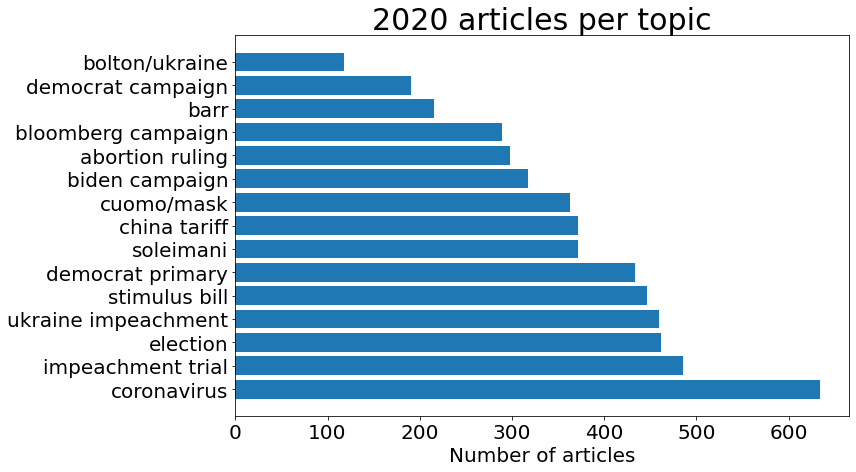

In [110]:
fig, ax = plt.subplots(figsize=(11,7))

ax.set_title("2020 articles per topic")
ax.set_xlabel("Number of articles")

ax.barh([topic_dict_2020[i] for i in df_politics_2020.topic.value_counts().index.values], df_politics_2020.topic.value_counts())

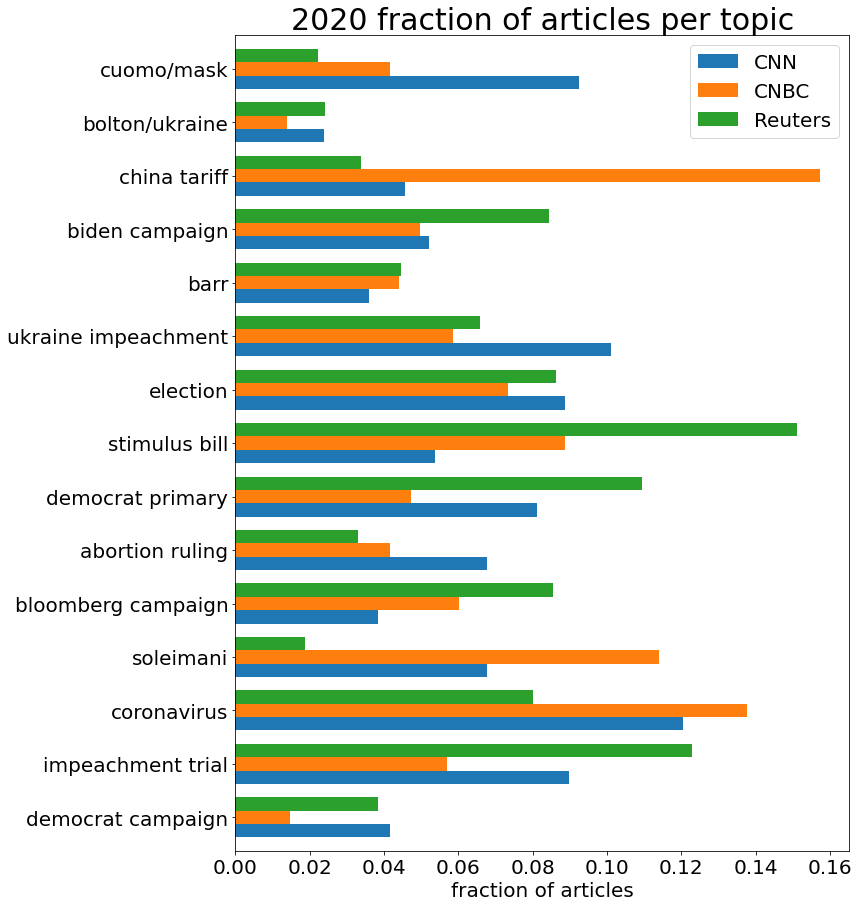

In [263]:
topic_dict_2020
fig, ax = plt.subplots(figsize=(11,15))

ax.set_title("2020 fraction of articles per topic")
ax.set_xlabel("fraction of articles")

cols_to_keep = df_politics_2020.groupby("publication").count().sort_values(by="id", ascending=False).index[:-1]
(df_politics_2020.groupby(["topic", "publication"]).count()["id"].unstack(fill_value=0) / df_politics_2020.groupby(["topic", "publication"]).count()["id"].unstack(fill_value=0).sum())[cols_to_keep].plot(kind="barh", ax=ax, width=0.75)

ax.set_ylabel(None)
ax.set_yticklabels([topic_dict_2020[i] for i in range(15)])
ax.legend(fontsize=20)